<a href="https://colab.research.google.com/github/bhattacharjee/silver-garbanzo/blob/main/ransomware_detection_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introuction

Brief outline of this notebook:

1. We start by importing some necessary modules
2. We load a prepared dataset containing encrypted and plaintext files
3. We train a neural network to detect to detect encrypted content
4. We explore the data to get a sense of how the neural network might have made it's decision.
5. We use this information to run an attack (we have already pre-processed the adversarial dataset)
6. We use the trained model to predict the labels on the adversarial dataset.
7. Finally we explore the data to see what went wrong.


## Import some modules and download the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import IPython

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


!git clone https://github.com/bhattacharjee/silver-garbanzo.git >/dev/null 2>&1
!cp -r silver-garbanzo/data/*.gz .
!ls

expanded.pyencrypted_v1.b32.csv.gz  model.png		       sample_data
expanded.pyencrypted_v1.csv.gz	    plaintext.expanded.csv.gz  silver-garbanzo


In [2]:
df_plaintext = pd.read_csv('plaintext.expanded.csv.gz')
df_plaintext["encrypted"] = 0
df_plaintext = df_plaintext[df_plaintext["extension"] != ".webp"]

df_encrypted = pd.read_csv('expanded.pyencrypted_v1.csv.gz')
df_encrypted["encrypted"] = 1
df_encrypted[df_encrypted["extension"] != ".webp"]

df_encrypted_base32 = pd.read_csv('expanded.pyencrypted_v1.b32.csv.gz')
df_encrypted_base32["encrypted"] = 1
df_encrypted_base32[df_encrypted_base32["extension"] != ".webp"]

training_and_validation_data = pd.concat([df_plaintext, df_encrypted])

# Drop the file type, and scale the data
# Scaling is necessary for any machine learning, especially neural networks,
# which don't work without scaling.

training_and_validation_data.drop(\
                                columns=['filename', 'extension'], \
                                inplace=True)
df_encrypted_base32.drop(columns=['filename', 'extension'], inplace=True)

scaler = MinMaxScaler()
training_and_validation_data = scaler.fit_transform(training_and_validation_data)
train_columns = [c for c in df_encrypted_base32.columns if "encrypted" != c]

df_encrypted_base32 = scaler.transform(df_encrypted_base32)

# Split columsn into features and target labels
# X represents the features, and y the target labels
X, y = training_and_validation_data[:,:-1], training_and_validation_data[:,-1]

b32_X, b32_y = df_encrypted_base32[:,:-1], df_encrypted_base32[:,-1]


X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.1)
X_train, X_test, y_train, y_test = \
    train_test_split(X_train, y_train, test_size=0.2)

 We build a fully connected neural network and train it. Off the bat, we get
 a good test accuracy.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable para

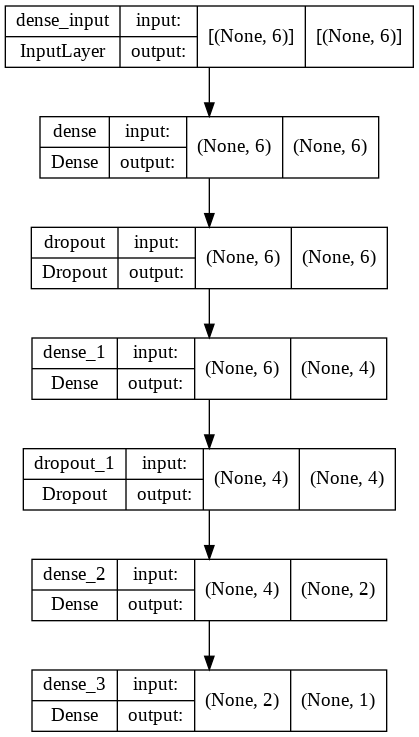

Epoch 1/20
5854/5854 [==============================] - 26s 4ms/step - loss: 0.4580 - accuracy: 0.7972 - val_loss: 0.2391 - val_accuracy: 0.9323
Epoch 2/20
5854/5854 [==============================] - 12s 2ms/step - loss: 0.2415 - accuracy: 0.9245 - val_loss: 0.1928 - val_accuracy: 0.9415
Epoch 3/20
5854/5854 [==============================] - 12s 2ms/step - loss: 0.2185 - accuracy: 0.9287 - val_loss: 0.1689 - val_accuracy: 0.9479
Epoch 4/20
5854/5854 [==============================] - 13s 2ms/step - loss: 0.2126 - accuracy: 0.9297 - val_loss: 0.1681 - val_accuracy: 0.9461
Epoch 5/20
5854/5854 [==============================] - 12s 2ms/step - loss: 0.2099 - accuracy: 0.9300 - val_loss: 0.1582 - val_accuracy: 0.9473
Epoch 6/20
5854/5854 [==============================] - 12s 2ms/step - loss: 0.2068 - accuracy: 0.9303 - val_loss: 0.1728 - val_accuracy: 0.9451
Epoch 7/20
5854/5854 [==============================] - 11s 2ms/step - loss: 0.2050 - accuracy: 0.9314 - val_loss: 0.1562 - val_ac

In [ ]:
class Model:
    def create(X):
        model = tf.keras.Sequential(
            [
                layers.Dense(6, input_dim=X.shape[1], activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(4, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(2, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ]
        )
        model.compile(\
                      loss='binary_crossentropy', \
                      optimizer='adam', \
                      metrics=['accuracy'])
        Model.print_and_plot(model)
        return model
    
    def print_and_plot(model):
        print(model.summary())
        plot = tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            expand_nested=True)
        IPython.display.display(plot)

model = Model.create(X_train)

history = model.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),
            batch_size=16)
